In [1]:
import pandas as pd, keras as k, numpy as np, matplotlib.pyplot as plt, os, re, glob

import joblib

from scipy.stats import pearsonr

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Attention
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

In [3]:
csv_logger= CSVLogger('training.log', append=True, separator=',')

In [4]:
# set the korean font for matplotlib
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)


In [5]:

# read ./DATA/POST_DATA/all_data.csv
data = pd.read_csv('./POST_DATA/all_data.csv', encoding='cp949', index_col=0, parse_dates=True)

# slice data < 2021-12-31
data = data.loc[:'2019-12-31']

raw_index = data['유해남조류세포수'].dropna(axis=0).index

# interpolate nan values in '유해남조류세포수'
# condition 1 : the period of nan value is less than 14 rows : interpolate nan value with linear method
# condtionn 2 : the period of nan value is more than 14 rows : no action
data['유해남조류세포수'] = data['유해남조류세포수'].interpolate(method='linear', limit=14, limit_direction='both')

# # apply log scale to '유해남조류세포수'
# data['유해남조류세포수'] = np.log(data['유해남조류세포수'])

# # # fill nan values or -inf values with 0 in '유해남조류세포수'
# data['유해남조류세포수'] = data['유해남조류세포수'].replace(-np.inf, np.nan)

# make target column
data['유해남조류세포수_Y'] = data['유해남조류세포수'].shift(-1)

# drop column '유해남조류세포수'
# data = data.drop('유해남조류세포수', axis=1)

# calculte % of nan values in each columns of data
nan_df = pd.DataFrame(data.isnull().sum()/len(data)*100, columns=['% of NaN'])
print(nan_df, '\n',data.shape)

             % of NaN
평균기온        21.535685
최저기온        21.507685
최고기온        21.504573
일강수량        21.485906
최대풍속        21.504573
평균풍속        21.526352
수위_DAY       0.790243
유량_DAY       5.155249
수온          18.925394
용존산소        20.869890
총유기탄소       25.452679
클로로필        20.854334
보방류량_DAY     1.851160
보유입량_DAY     1.866716
보저수량_DAY     0.018667
보저수위_DAY     0.000000
수온_WEK      23.931305
pH_WEK      23.931305
DO_WEK      23.931305
투명도_WEK     91.652666
탁도_WEK      91.652666
Chl-a _WEK  23.931305
유해남조류세포수    19.914753
유해남조류세포수_Y  19.914753 
 (32142, 24)


In [6]:
data['유해남조류세포수_Y']

index
2012-01-01      NaN
2012-01-02      NaN
2012-01-03      NaN
2012-01-04      NaN
2012-01-05      NaN
              ...  
2019-12-27    143.0
2019-12-28    143.0
2019-12-29    143.0
2019-12-30    143.0
2019-12-31      NaN
Name: 유해남조류세포수_Y, Length: 32142, dtype: float64

In [7]:
nan_df.to_csv('./model_attn/var_info.csv', encoding='cp949')

In [8]:
data.dropna(axis=0)

,평균기온,최저기온,최고기온,일강수량,최대풍속,평균풍속,수위_DAY,유량_DAY,수온,용존산소,...,보저수량_DAY,보저수위_DAY,수온_WEK,pH_WEK,DO_WEK,투명도_WEK,탁도_WEK,Chl-a _WEK,유해남조류세포수,유해남조류세포수_Y
index,,,,,,,,,,,,,,,,,,,,,
2016-03-21,9.6,2.6,17.0,0.0,2.5,0.9,1.75,24.59,11.5,12.5,...,32.52,32.52,12.600000,7.9,11.600000,1.200000,2.700000,8.800000,0.000000,0.000000
2016-03-22,11.6,2.3,19.4,0.0,3.7,1.7,1.73,23.77,11.3,12.8,...,32.55,32.55,12.600000,7.9,11.600000,1.200000,2.700000,8.800000,0.000000,0.000000
2016-03-23,10.9,7.2,16.1,0.0,3.5,1.7,1.74,23.91,11.9,12.4,...,32.50,32.50,12.600000,7.9,11.600000,1.200000,2.700000,8.800000,0.000000,0.000000
2016-03-24,8.0,4.3,13.2,0.3,3.2,1.3,1.74,54.19,12.0,12.0,...,32.52,32.52,12.600000,7.9,11.600000,1.200000,2.700000,8.800000,0.000000,0.000000
2016-03-25,7.2,3.8,11.9,0.4,2.8,1.2,1.72,33.43,11.5,11.5,...,32.53,32.53,12.600000,7.9,11.600000,1.200000,2.700000,8.800000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,1.2,-1.9,5.7,0.0,3.1,1.7,1.78,101.10,5.2,12.6,...,53.06,32.55,4.842857,8.5,13.871429,1.485714,1.942857,13.000000,14.571429,9.714286
2019-12-28,-0.5,-5.9,6.9,0.0,1.4,0.4,1.77,34.08,4.8,12.8,...,53.12,32.56,4.728571,8.5,13.914286,1.557143,1.928571,13.300000,9.714286,4.857143
2019-12-29,0.2,-4.9,4.7,4.1,1.5,0.4,1.80,28.25,4.7,13.0,...,53.19,32.57,4.614286,8.5,13.957143,1.628571,1.914286,13.600000,4.857143,0.000000


In [8]:
# # plot time series of each columns using for loop
# for i in data.columns:
#     plt.figure(figsize=(18,3))
#     plt.plot(data[i], 'ko')
#     plt.title(i)
#     plt.show()


In [9]:
# drop columns if nan is over 30% and apply all columns except '유해남조류세포수_Y'
droprate = 0.30
for i in data.columns:
    if nan_df.loc[i, '% of NaN'] > droprate*100 and i != '유해남조류세포수_Y':
        data = data.drop(i, axis=1)


# # drop columns if nan is over 30%
# droprate = 0.30
# print(data.shape)
# data = data.dropna(axis=1, thresh=len(data)*(1-droprate))
# print(data.shape)

# calculte % of nan values in each columns of data
nan_df = pd.DataFrame(data.isnull().sum()/len(data)*100, columns=['% of NaN'])
print(nan_df, '\n',data.shape)

             % of NaN
평균기온        21.535685
최저기온        21.507685
최고기온        21.504573
일강수량        21.485906
최대풍속        21.504573
평균풍속        21.526352
수위_DAY       0.790243
유량_DAY       5.155249
수온          18.925394
용존산소        20.869890
총유기탄소       25.452679
클로로필        20.854334
보방류량_DAY     1.851160
보유입량_DAY     1.866716
보저수량_DAY     0.018667
보저수위_DAY     0.000000
수온_WEK      23.931305
pH_WEK      23.931305
DO_WEK      23.931305
Chl-a _WEK  23.931305
유해남조류세포수    19.914753
유해남조류세포수_Y  19.914753 
 (32142, 22)


In [17]:
x_features = data.iloc[:,:-1].shape[1]
print(x_features)

21


In [18]:
def create_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1): 
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(axis=0, how='any', inplace=True)
    return agg

In [23]:
# input_df is data without '유해남조류세포수'
input_df = data.drop(['유해남조류세포수_Y'], axis=1)
otput_df = data[['유해남조류세포수_Y']]

input_cols = input_df.columns

# normalize features
scaler = StandardScaler()
scaler.fit(input_df)
scaled = scaler.fit_transform(input_df)

# save min, max values
min_values = input_df.min()
max_values = input_df.max()

input_df = pd.DataFrame(scaled, columns=input_df.columns, index=input_df.index)

input_df = create_dataset(input_df, n_in=7, n_out=0, dropnan=False)
otput_df = create_dataset(otput_df, n_in=0, n_out=1, dropnan=False)

model_df = pd.concat([input_df, otput_df], axis=1)
model_df = model_df.loc[raw_index].dropna(axis=0)

#shuffle data
model_df = model_df.sample(frac=1)

# print(model_df.shape)
print(input_df)
print(input_df.shape)

            var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)   
index                                                                          
2012-01-01        NaN        NaN        NaN        NaN        NaN        NaN  \
2012-01-02        NaN        NaN        NaN        NaN        NaN        NaN   
2012-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
2012-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
2012-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2019-12-27  -1.208795  -1.230382  -0.959405  -0.268876   0.301822  -0.732538   
2019-12-28  -1.508156  -1.299978  -1.486078  -0.268876  -1.290206  -1.060802   
2019-12-29  -1.322346  -1.240324  -1.141715  -0.268876  -1.349170  -1.060802   
2019-12-30  -1.136536  -1.260209  -0.716325  -0.268876   0.360786  -0.404273   
2019-12-31  -1.177827  -1.140901  -0.837

In [20]:
model_df

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var1(t)
index,,,,,,,,,,,,,,,,,,,,,
2016-09-26,0.618338,0.907224,0.377536,-0.268876,-1.054350,-0.732538,-1.182380,-0.274727,0.452381,-1.841226,...,-0.165251,-0.178972,-0.513665,1.300007,0.509914,-0.317705,-0.826449,-0.583800,-0.190447,619.750000
2019-08-26,1.186091,1.056359,1.086519,-0.268876,-1.231242,-1.060802,-0.596990,-0.497765,1.286425,0.410829,...,-0.239162,-0.236209,-0.825064,1.825856,0.861728,-0.528347,-1.351377,-0.517987,-0.160402,610.000000
2019-10-28,0.102198,0.101893,0.357279,-0.268876,-0.346782,-0.732538,-0.842764,-0.390815,0.274452,-0.022259,...,0.492676,0.478054,-0.188297,-1.504521,0.133089,-1.370916,-0.157857,-0.073282,-0.203187,218.142857
2019-07-22,0.938344,1.195552,0.772541,0.863399,-0.995386,-0.732538,-0.159065,-0.450226,1.008410,-1.451447,...,1.555388,1.542687,-0.187027,0.744449,1.055142,-1.009815,-1.047472,-0.505765,-0.203377,247.571429
2019-03-11,-0.300390,-0.405167,-0.179523,-0.268876,0.183894,-0.294852,0.278860,-0.498632,-0.670797,2.056561,...,-0.349453,-0.359099,0.935632,-1.313641,-0.758951,1.487800,1.748461,0.545357,-0.205348,114.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-02,1.113832,1.066301,1.167546,-0.268876,-1.290206,-0.732538,1.909908,2.368276,1.430993,-1.061669,...,0.350755,0.296135,0.271180,-0.879147,1.451975,0.474711,-0.614636,1.863489,0.101074,8550.000000
2017-07-03,0.876407,1.145840,0.782669,1.297579,-0.759530,-1.060802,-0.176939,-0.480405,1.064013,-1.234904,...,-0.225396,-0.198902,-0.166962,0.753362,1.090157,0.193855,-1.178704,-0.578159,0.704094,22556.333333
2015-04-06,0.122844,-0.425051,0.549717,-0.268876,0.183894,0.142834,-0.404839,-0.488692,-0.415024,0.021050,...,-0.267895,-0.270095,-0.817698,1.831055,-0.517183,-0.498255,0.146049,-0.278241,-0.209247,0.000000


In [22]:
X

array([[[ 0.61833778,  0.90722373,  0.37753565, ..., -1.091676  ,
         -0.97303432, -0.20361497],
        [ 0.44285041,  0.33056733,  0.62061572, ..., -1.04747153,
         -0.90816189, -0.2014203 ],
        [ 0.39123647,  0.20131676,  0.51933236, ..., -1.00326707,
         -0.84328945, -0.19922562],
        ...,
        [ 0.64930614,  0.62883788,  0.79279744, ..., -0.91485814,
         -0.71354458, -0.19483627],
        [ 0.752534  ,  0.82768491,  0.8940808 , ..., -0.87065368,
         -0.64867215, -0.19264159],
        [ 0.63898335,  0.68849199,  0.52946069, ..., -0.82644922,
         -0.58379971, -0.19044691]],

       [[ 1.18609104,  1.056359  ,  1.0865192 , ..., -1.28507052,
         -0.47285845,  0.06268356],
        [ 1.25835054,  1.33474485,  1.1169042 , ..., -1.29612164,
         -0.48037989,  0.0255026 ],
        [ 1.25835054,  1.21543663,  1.18780256, ..., -1.30717275,
         -0.48790133, -0.01167836],
        ...,
        [ 1.1344771 ,  1.17566722,  0.98523583, ..., -

In [21]:
X = model_df.iloc[:,:-1].values.reshape(model_df.shape[0], 7, x_features)
y = model_df.iloc[:,-1].values.reshape(model_df.shape[0], 1)

print(X.shape, y.shape)


(12584, 7, 21) (12584, 1)


In [14]:
# train, validation, test 데이터셋으로 분할
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# print all data shape
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(10067, 7, 21) (10067, 1)
(1258, 7, 21) (1258, 1)
(1259, 7, 21) (1259, 1)


In [15]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W1 = self.add_weight(name='W1', shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.W2 = self.add_weight(name='W2', shape=(self.units, self.units), initializer='glorot_uniform', trainable=True)
        self.V = self.add_weight(name='V', shape=(self.units,), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        hidden_states = inputs
        score = tf.matmul(hidden_states, self.W1)
        score = tf.tanh(tf.matmul(score, self.W2))
        attention_weights = tf.nn.softmax(tf.matmul(score, tf.reshape(self.V, (-1, 1))), axis=1)
        context_vector = attention_weights * hidden_states
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(7, X_train.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(Attention(64))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [45]:

# model compile
# model.compile(optimizer='adam', loss='mse',)
model.compile(optimizer='adam', loss='mse', metrics=['msle','mape',tf.keras.metrics.CosineSimilarity(axis=1)])

# model training
es = EarlyStopping(monitor='val_loss', patience=16, verbose=1, mode='min')

history = model.fit(X_train, y_train,
                    # epochs=1000,
                    epochs=3,
                    batch_size=32,
                    verbose=2,
                    validation_data=(X_val, y_val),
                    callbacks=[es,csv_logger])



Epoch 1/3
315/315 - 10s - loss: 974711232.0000 - msle: 2.1676 - mape: 2901084672.0000 - cosine_similarity: 0.7511 - val_loss: 862408896.0000 - val_msle: 2.1643 - val_mape: 3375579136.0000 - val_cosine_similarity: 0.7432 - 10s/epoch - 32ms/step
Epoch 2/3
315/315 - 3s - loss: 954651648.0000 - msle: 2.6243 - mape: 6342052864.0000 - cosine_similarity: 0.7511 - val_loss: 841372608.0000 - val_msle: 2.7051 - val_mape: 6531731968.0000 - val_cosine_similarity: 0.7432 - 3s/epoch - 9ms/step
Epoch 3/3
315/315 - 3s - loss: 933607488.0000 - msle: 2.5158 - mape: 5175512064.0000 - cosine_similarity: 0.7511 - val_loss: 820790848.0000 - val_msle: 2.4655 - val_mape: 3532314880.0000 - val_cosine_similarity: 0.7432 - 3s/epoch - 9ms/step


In [46]:
test_score = model.evaluate(X_test, y_test, verbose=0)

In [47]:
test_score[0]

1103620352.0

In [48]:
test_score[1]

2.4573888778686523

In [49]:
np.sqrt(test_score[1])

1.5676060978028417

In [38]:
test_score[2]

0.7339158058166504

In [ ]:
# model evaluate
mse_train = model.evaluate(X_train, y_train, verbose=0)
mse_val = model.evaluate(X_val, y_val, verbose=0)
mse_test = model.evaluate(X_test, y_test, verbose=0)

print("MSE Train:", mse_train)
print("MSE Validation:", mse_val)
print("MSE Test:", mse_test)

In [24]:
len(np.round(tf.keras.metrics.mean_absolute_error(y_test, model.predict(X_test)),2))

40/40 [==============================] - 0s 6ms/step


1259

In [21]:
np.sqrt(mse_test)

36406.62621007335

In [15]:
# # save model and scaler using keras library
# model.save('model.h5')

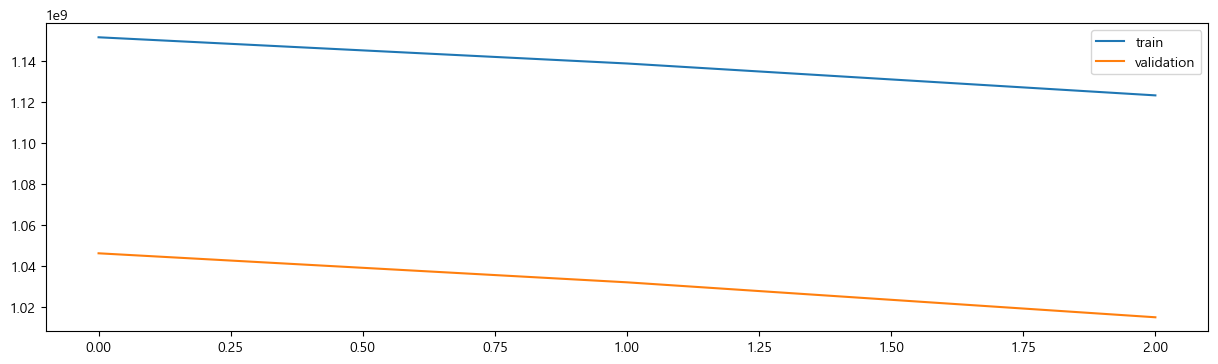

In [19]:
# plot the loss and accuracy
fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.savefig('./model_attn/result/loss.png', facecolor='white', dpi=300)
plt.show()
plt.close()



In [40]:
# prediction
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

40/40 [==============================] - 1s 4ms/step


In [50]:
raw_index

DatetimeIndex(['2012-01-05', '2012-01-10', '2012-01-16', '2012-01-25',
               '2012-01-30', '2012-02-07', '2012-02-13', '2012-02-20',
               '2012-02-27', '2012-02-28',
               ...
               '2019-10-21', '2019-10-28', '2019-11-04', '2019-11-11',
               '2019-11-18', '2019-11-25', '2019-12-02', '2019-12-09',
               '2019-12-16', '2019-12-23'],
              dtype='datetime64[ns]', name='index', length=4191, freq=None)

In [51]:
len(y_test)

1259

In [60]:
y_pred

array([[   20.510805],
       [ 1399.8984  ],
       [  251.87514 ],
       ...,
       [ 1290.8965  ],
       [12399.846   ],
       [   22.469667]], dtype=float32)

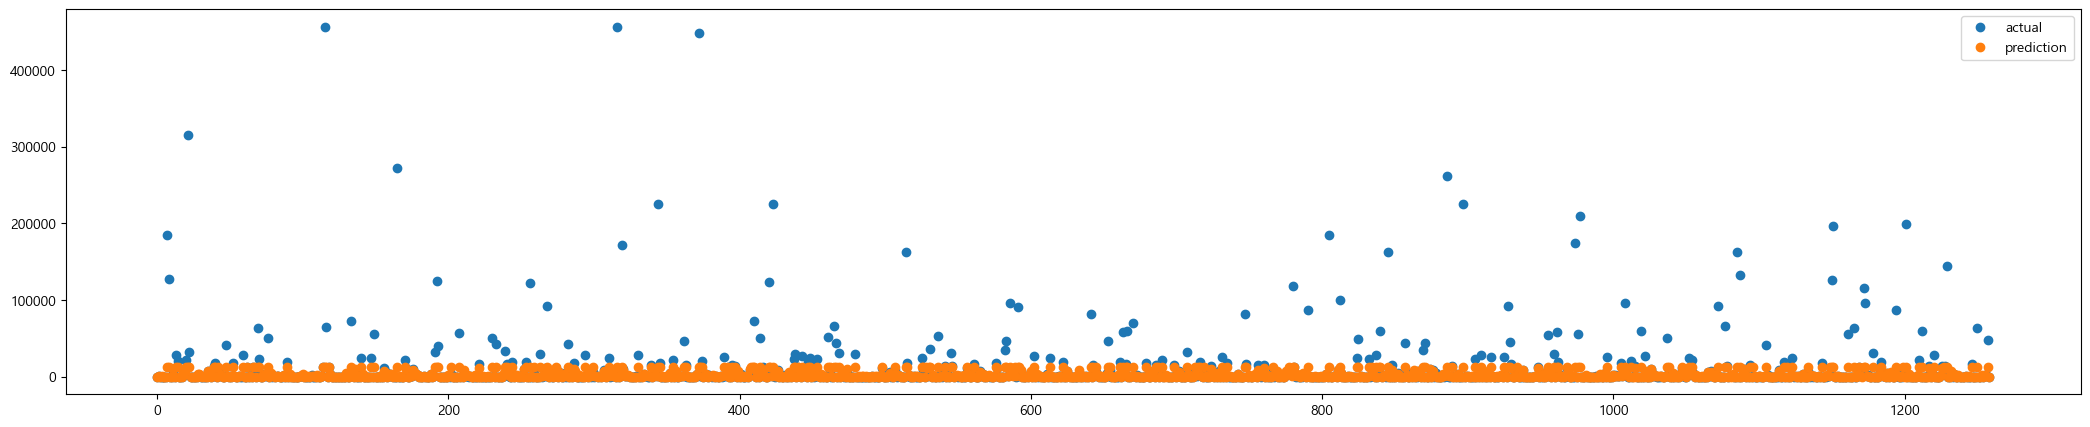

In [43]:
# plot the prediction
fig, ax = plt.subplots(figsize=(26, 5))
plt.plot(y_test, 'o', label='actual')
plt.plot(y_pred, 'o', label='prediction')
plt.legend()
plt.show()

In [19]:
# plot the model 



In [20]:
# # plot the model structure
# tf.keras.utils.plot_model(model, to_file='./model_attn/result/model.png', show_shapes=True, dpi=300)

In [21]:
input_cols

Index(['평균기온', '최저기온', '최고기온', '일강수량', '최대풍속', '평균풍속', '수위_DAY', '유량_DAY',
       '수온', '용존산소', '총유기탄소', '클로로필', '보방류량_DAY', '보유입량_DAY', '보저수량_DAY',
       '보저수위_DAY', '수온_WEK', 'pH_WEK', 'DO_WEK', 'Chl-a _WEK'],
      dtype='object')

(1096, 21)
(0, 147)
./POST_DATA\낙동강_강정고령.csv
(1096, 21)
(0, 147)
./POST_DATA\낙동강_강정고령보.csv
(1096, 21)
(147, 147)
5/5 [==============================] - 0s 5ms/step
{'낙동강_구미보': {'prediction': {'2019-02-07': 4.666872978210449, '2019-02-11': 4.553552627563477, '2019-02-18': 4.420073509216309, '2019-02-25': 5.31310510635376, '2019-03-04': 5.0805230140686035, '2019-03-11': 4.980675220489502, '2019-03-19': 3.5290141105651855, '2019-03-25': 5.332526206970215, '2019-04-02': 5.264341354370117, '2019-04-08': 5.950403690338135, '2019-04-15': 10.12851333618164, '2019-04-22': 8.310247421264648, '2019-04-29': 11.754437446594238, '2019-05-07': 12.557445526123047, '2019-05-13': 13.446755409240723, '2019-05-20': 150.33978271484375, '2019-05-28': 14.301118850708008, '2019-06-03': 40.81011199951172, '2019-06-10': 678.4299926757812, '2019-06-17': 783.2808227539062, '2019-06-24': 1740.532958984375, '2019-07-01': 1027.9866943359375, '2019-07-08': 9089.341796875, '2019-07-15': 19450.556640625, '2019-07-18': 

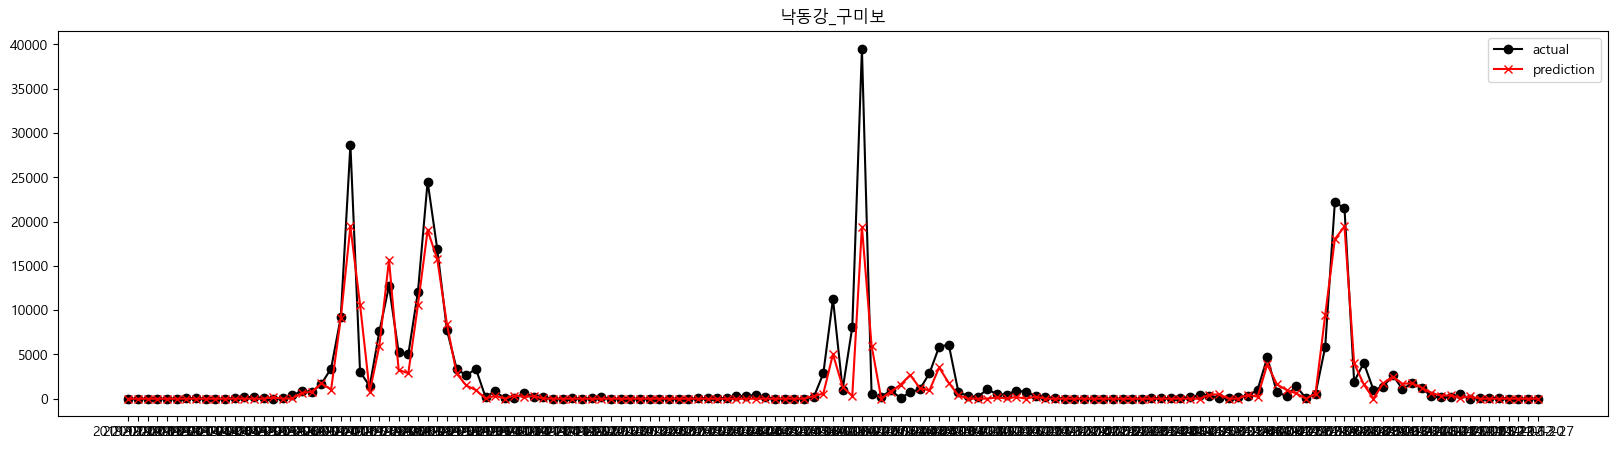

(1096, 21)
(140, 147)
5/5 [==============================] - 0s 4ms/step
{'낙동강_낙단보': {'prediction': {'2019-02-18': 3.763859510421753, '2019-02-25': 4.053531169891357, '2019-03-04': 4.206835746765137, '2019-03-11': 5.308991432189941, '2019-03-18': 4.391181468963623, '2019-03-25': 4.815542221069336, '2019-04-01': 4.722513198852539, '2019-04-08': 5.609475612640381, '2019-04-15': 6.738829135894775, '2019-04-22': 5.6233391761779785, '2019-04-29': 7.09328556060791, '2019-05-07': 9.65317153930664, '2019-05-13': 11.093037605285645, '2019-05-20': 12.001104354858398, '2019-05-28': 154.97320556640625, '2019-06-03': 1259.6993408203125, '2019-06-10': 338.4505920410156, '2019-06-17': 211.11448669433594, '2019-06-24': 679.1356201171875, '2019-07-01': 370.0664367675781, '2019-07-08': 901.1370239257812, '2019-07-15': 19436.375, '2019-07-18': 7434.65869140625, '2019-07-22': 657.2467651367188, '2019-07-29': 7852.73583984375, '2019-08-05': 19438.060546875, '2019-08-08': 19463.833984375, '2019-08-12': 5886

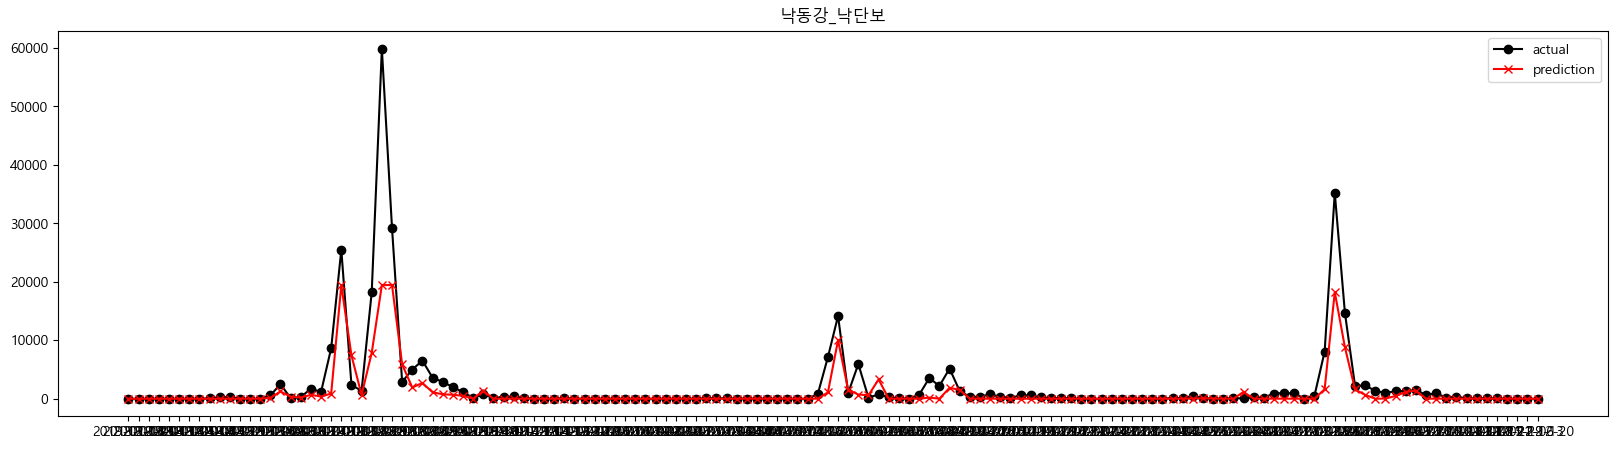

(1096, 21)
(0, 147)
./POST_DATA\낙동강_달성보.csv
(1096, 21)
(83, 147)
3/3 [==============================] - 0s 4ms/step
{'낙동강_물금메리': {'prediction': {'2020-05-18': 49.311431884765625, '2020-05-25': 24.314599990844727, '2020-06-01': 632.2625122070312, '2020-06-08': 1718.67333984375, '2020-06-15': 3263.929931640625, '2020-06-22': 2820.861328125, '2020-06-29': 14233.0283203125, '2020-07-06': 18962.279296875, '2020-07-16': 6755.1513671875, '2020-07-20': 580.625732421875, '2020-07-30': 1516.2147216796875, '2020-08-03': 675.8909301757812, '2020-08-18': 2484.533447265625, '2020-08-25': 13054.78515625, '2020-09-14': 3655.170166015625, '2020-09-21': 411.04949951171875, '2020-09-28': 854.298828125, '2020-10-05': 3760.781982421875, '2020-10-12': 863.2197265625, '2020-10-19': 4496.4072265625, '2020-10-26': 244.64370727539062, '2020-11-02': 273.1888427734375, '2020-11-09': 111.22596740722656, '2020-11-16': 235.38401794433594, '2020-11-23': 10.990556716918945, '2020-11-30': 224.24118041992188, '2020-12-0

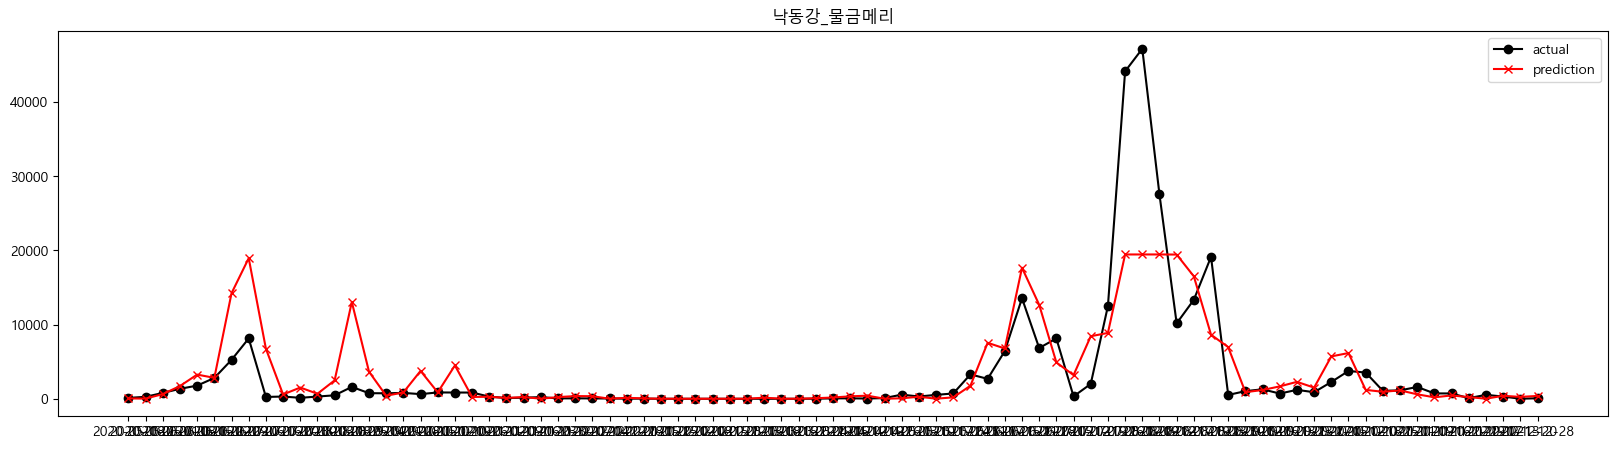

(1096, 21)
(138, 147)
5/5 [==============================] - 0s 3ms/step
{'낙동강_상주보': {'prediction': {'2019-02-25': 4.25945520401001, '2019-03-04': 5.268759250640869, '2019-03-11': 4.799282073974609, '2019-03-18': 4.309414863586426, '2019-03-25': 5.58829402923584, '2019-04-01': 5.120158672332764, '2019-04-08': 5.312618255615234, '2019-04-15': 7.085071563720703, '2019-04-22': 5.829524993896484, '2019-04-29': 6.179332256317139, '2019-05-07': 9.281729698181152, '2019-05-13': 311.7916259765625, '2019-05-20': 13.231304168701172, '2019-05-28': 385.4217224121094, '2019-06-03': 3703.55078125, '2019-06-10': 574.8245849609375, '2019-06-17': 375.4833679199219, '2019-06-24': 851.1551513671875, '2019-07-01': 271.62213134765625, '2019-07-08': 3225.677001953125, '2019-07-15': 1605.4029541015625, '2019-07-22': 403.8689270019531, '2019-07-29': 3339.022705078125, '2019-08-05': 19238.205078125, '2019-08-08': 19458.552734375, '2019-08-12': 19356.095703125, '2019-08-16': 5887.74609375, '2019-08-19': 5569.70

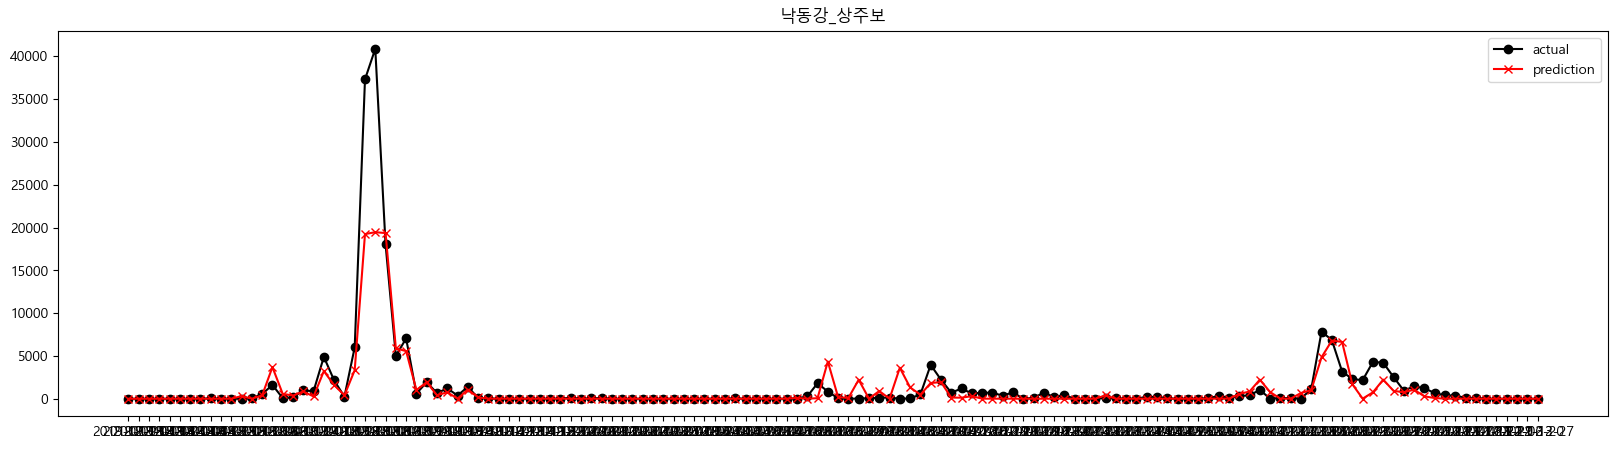

(1096, 21)
(147, 147)
5/5 [==============================] - 0s 3ms/step
{'낙동강_창녕함안보': {'prediction': {'2019-01-14': 88.2112808227539, '2019-01-21': 115.32018280029297, '2019-01-28': 4.458239555358887, '2019-02-07': 31.409982681274414, '2019-02-11': 4.265460014343262, '2019-02-18': 4.3583574295043945, '2019-02-25': 5.436772346496582, '2019-03-04': 5.373742580413818, '2019-03-11': 4.212192535400391, '2019-03-18': 4.65040397644043, '2019-03-25': 4.870296478271484, '2019-04-01': 5.485529899597168, '2019-04-08': 80.53182983398438, '2019-04-15': 98.9596939086914, '2019-04-22': 97.15901184082031, '2019-04-29': 765.8165893554688, '2019-05-07': 13.055927276611328, '2019-05-13': 418.8248291015625, '2019-05-20': 331.3092041015625, '2019-05-28': 84.577392578125, '2019-06-03': 2840.489990234375, '2019-06-10': 8198.822265625, '2019-06-17': 19450.978515625, '2019-06-24': 19464.8515625, '2019-07-01': 19464.349609375, '2019-07-08': 19464.033203125, '2019-07-15': 19465.099609375, '2019-07-22': 19465.21

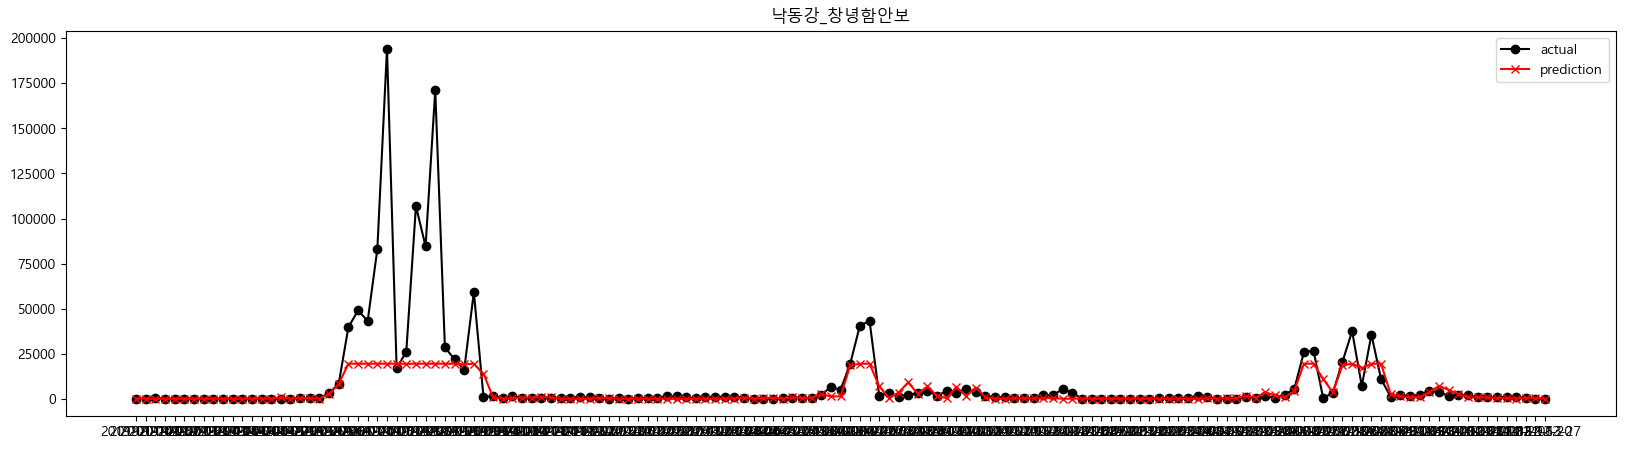

(1096, 21)
(145, 147)
5/5 [==============================] - 0s 3ms/step
{'낙동강_칠곡보': {'prediction': {'2019-01-28': 3.8611795902252197, '2019-02-07': 3.994619131088257, '2019-02-11': 3.842149496078491, '2019-02-18': 3.9172282218933105, '2019-02-25': 4.167383670806885, '2019-03-04': 4.3114399909973145, '2019-03-11': 4.342912673950195, '2019-03-18': 4.802578926086426, '2019-03-25': 5.755607604980469, '2019-04-01': 4.8572187423706055, '2019-04-08': 4.591912269592285, '2019-04-15': 6.724490642547607, '2019-04-22': 5.5561065673828125, '2019-04-29': 8.203756332397461, '2019-05-07': 164.3682098388672, '2019-05-13': 250.78770446777344, '2019-05-20': 729.173095703125, '2019-05-28': 60.29917907714844, '2019-06-03': 544.4315185546875, '2019-06-10': 1087.9471435546875, '2019-06-17': 2107.0087890625, '2019-06-24': 13982.337890625, '2019-07-01': 19023.546875, '2019-07-08': 10287.380859375, '2019-07-15': 355.8150939941406, '2019-07-22': 38.70319366455078, '2019-07-29': 1766.35107421875, '2019-08-05': 

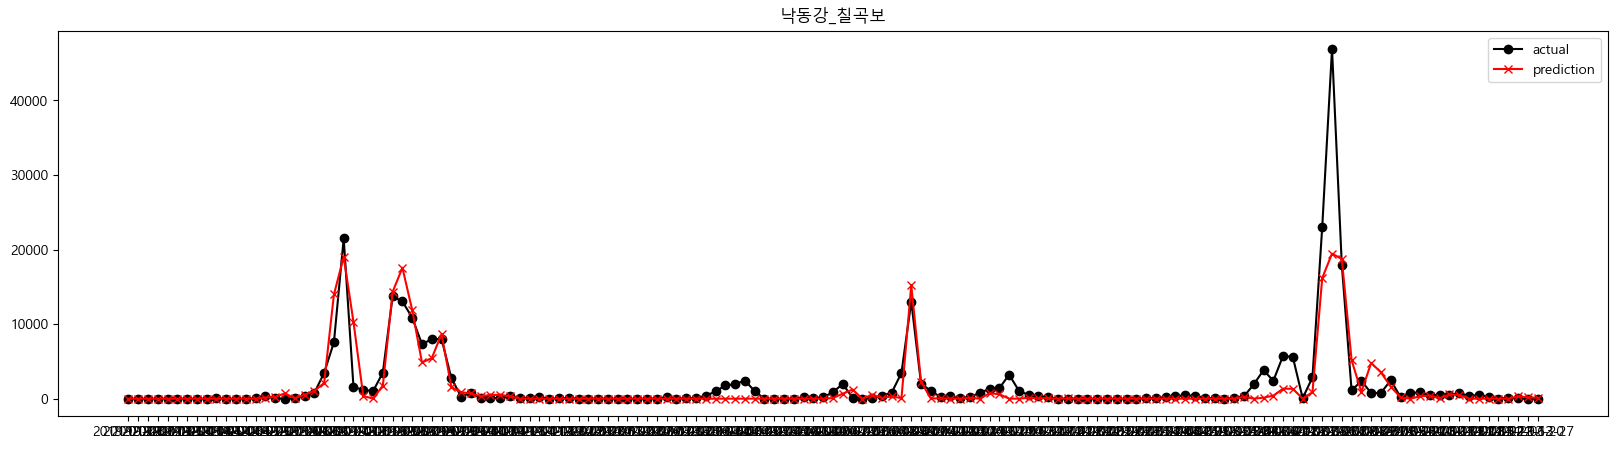

./POST_DATA\낙동강_칠서.csv
(1096, 21)
(165, 147)
6/6 [==============================] - 0s 3ms/step
{'낙동강_합천창녕보': {'prediction': {'2019-01-14': 7.428610324859619, '2019-01-21': 6.992728233337402, '2019-01-28': 6.201651096343994, '2019-02-07': 6.2972564697265625, '2019-02-11': 4.564728736877441, '2019-02-18': 3.81439208984375, '2019-02-25': 9.886473655700684, '2019-03-04': 4.689891338348389, '2019-03-11': 48.77739715576172, '2019-03-18': 4.8545026779174805, '2019-03-25': 4.740900993347168, '2019-04-01': 4.331903457641602, '2019-04-08': 19.427709579467773, '2019-04-15': 12.544377326965332, '2019-04-22': 9.180083274841309, '2019-04-29': 96.83299255371094, '2019-05-07': 12.839605331420898, '2019-05-13': 10.080984115600586, '2019-05-20': 14.116680145263672, '2019-05-28': 232.15858459472656, '2019-06-03': 3393.936279296875, '2019-06-10': 11880.78515625, '2019-06-13': 16124.537109375, '2019-06-17': 19447.865234375, '2019-06-20': 19463.6015625, '2019-06-24': 19464.234375, '2019-06-27': 19465.14062

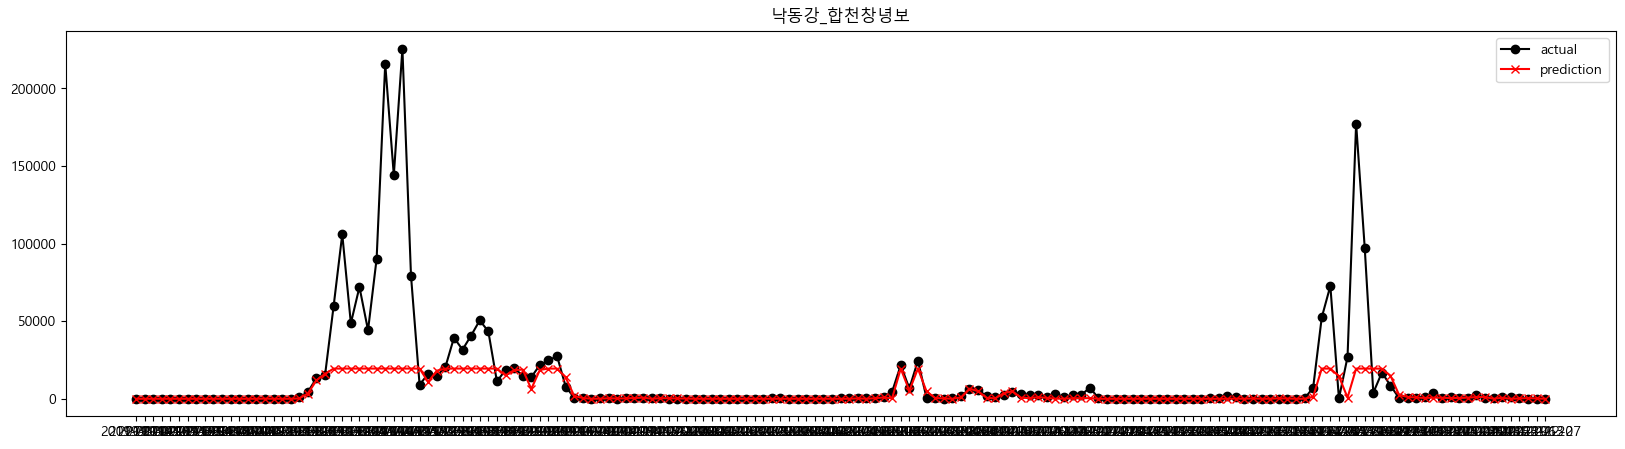

(1096, 21)
(140, 147)
5/5 [==============================] - 0s 4ms/step
{'낙동강_해평': {'prediction': {'2019-02-18': 4.257538795471191, '2019-02-25': 5.572824478149414, '2019-03-04': 6.1318488121032715, '2019-03-11': 5.242763519287109, '2019-03-18': 4.1728925704956055, '2019-03-25': 6.331304550170898, '2019-04-01': 6.417043685913086, '2019-04-08': 5.341915130615234, '2019-04-15': 11.828125953674316, '2019-04-22': 10.015705108642578, '2019-04-29': 12.9172945022583, '2019-05-07': 12.338823318481445, '2019-05-13': 12.914140701293945, '2019-05-20': 14.637274742126465, '2019-05-29': 14.704849243164062, '2019-06-03': 16.817874908447266, '2019-06-10': 15.200128555297852, '2019-06-17': 203.5399932861328, '2019-06-24': 575.5521240234375, '2019-07-01': 392.5625305175781, '2019-07-09': 552.3592529296875, '2019-07-15': 514.4908447265625, '2019-07-22': 124.17608642578125, '2019-07-29': 736.6239013671875, '2019-08-05': 3701.728271484375, '2019-08-12': 927.09423828125, '2019-08-19': 1926.4638671875, '20

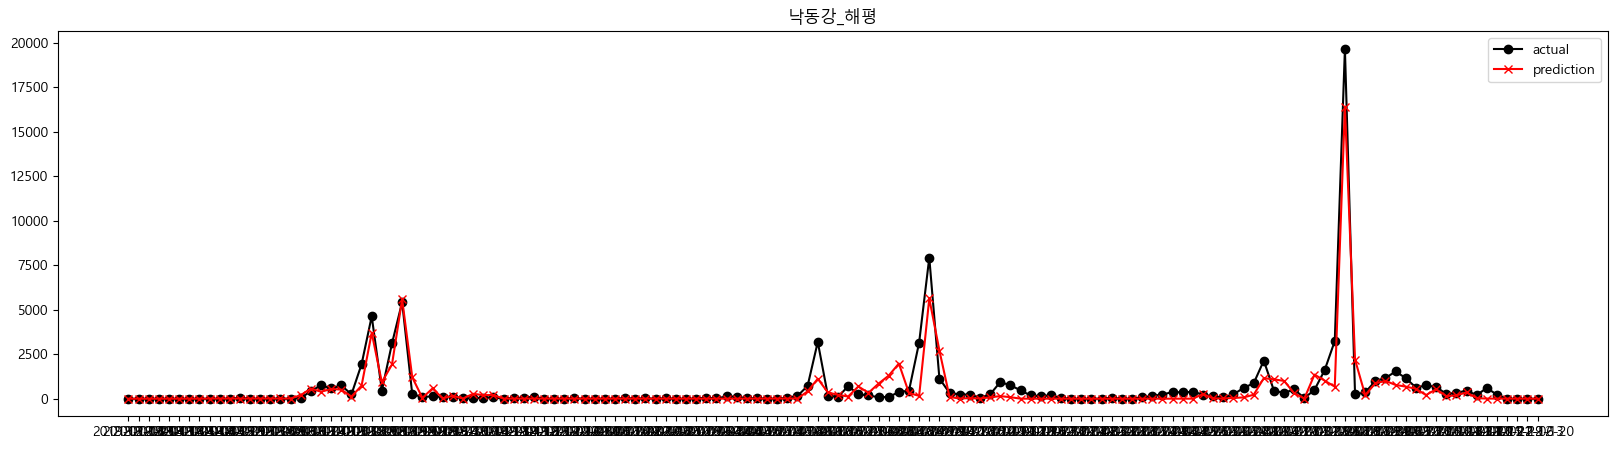

: 

In [63]:
# read post_datas
post_list = glob.glob('./POST_DATA/낙동강*.csv')

for post_path in post_list:

    try:
        point_name = post_path.split('\\')[-1].split('.')[0]
        # read test point data
        test_point_raw = pd.read_csv(post_path, encoding='cp949', index_col=0, parse_dates=True)

        # # slice period over 2023-01-01
        test_point_raw = test_point_raw.loc['2019-01-01':'2021-12-31']

        use_index = test_point_raw['유해남조류세포수'].dropna(axis=0).index

        # interpolate nan values in '유해남조류세포수'
        test_point_raw['유해남조류세포수'] = test_point_raw['유해남조류세포수'].interpolate(method='linear')

        # # apply log scale to '유해남조류세포수'
        # test_point_raw['유해남조류세포수'] = np.log(test_point_raw['유해남조류세포수'])

        # # fill nan values or -inf values with 0 in '유해남조류세포수'
        # test_point_raw['유해남조류세포수'] = test_point_raw['유해남조류세포수'].replace(-np.inf, 0)

        # make target column
        test_point_raw['유해남조류세포수_Y'] = test_point_raw['유해남조류세포수'].shift(-1)


        test_point = test_point_raw.copy()
        test_point = test_point[input_cols]

        test_point = test_point.interpolate(method='linear')

        print(test_point.shape)

        test_cols = test_point.columns
        test_indx = test_point.index

        # apply scaler 
        test_scaled = scaler.transform(test_point)

        test_scaled = pd.DataFrame(test_scaled, columns=test_cols, index=test_indx)

        # apply create_dataset function to test point data
        test_point = create_dataset(test_scaled, n_in=7,n_out=0, dropnan=False)
        test_point = test_point.loc[use_index]
        test_point = test_point.dropna(axis=0)
        print(test_point.shape)

        # reshape test point data
        test_point_input = test_point.values.reshape(test_point.shape[0], 7, x_features)

        # predict
        test_point_pred = model.predict(test_point_input)
        test_result = pd.DataFrame(test_point_pred, index=test_point.index, columns=['prediction'])
        rawd_result = test_point_raw.loc[test_point.index, ['유해남조류세포수_Y']]

        # # # inverse log
        # test_result['prediction_inv'] = test_result['prediction'].apply(lambda x: np.exp(x))
        # rawd_result['유해남조류세포수_Y_inv'] = rawd_result['유해남조류세포수_Y'].apply(lambda x: np.exp(x))

        # concat prediction and actual data
        test_result = pd.concat([test_result, rawd_result], axis=1)
        test_result.index = test_result.index.strftime('%Y-%m-%d')
        # save prediction and actual data
        # test_result.to_csv('./model_attn/result/{}.csv'.format(point_name), encoding='cp949')
        print({'{}'.format(point_name):test_result.to_dict()})

        # # plot the prediction
        # fig, ax = plt.subplots(figsize=(20, 5))
        # # ax.set_facecolor('white')
        # plt.plot(test_result['유해남조류세포수_Y_inv'], 'ko-', label='actual')
        # plt.plot(test_result['prediction_inv'], 'ro-', label='prediction')
        # plt.title(point_name)
        # plt.legend()

        # plt.savefig('./model_attn/result/{}.png'.format(point_name), facecolor='white', dpi=300)

        fig, ax = plt.subplots(figsize=(20, 5))
        # ax.set_facecolor('white')
        plt.plot(test_result['유해남조류세포수_Y'], 'ko-', label='actual')
        plt.plot(test_result['prediction'], 'rx-', label='prediction')
        plt.title(point_name)
        plt.legend()
        # plt.yscale('log')
        # plt.savefig('./model_attn/result/{}_log.png'.format(point_name), facecolor='white', dpi=300)
        

        plt.show()
        plt.close()
    except:
        print(post_path)
        pass

In [56]:
X.shape

(7, 21)

In [31]:
x_features

20

In [34]:
delta_x = np.linspace(-5, 5, 10)

vars_shap_list = []
for var in range(x_features):
    X_pert_pred = np.copy(X_test[1, 0, :].reshape(1, 1, x_features))
    x_pert = np.copy(X_test[:, 6, var])
    delta_y = np.zeros_like(delta_x)
    for i, dx in enumerate(np.linspace(x_pert.min(), x_pert.max(), 10)):
        sensi_val = dx
        X_pert_pred[0, 0, var] = sensi_val
        y_pert = model.predict(X_pert_pred)
        delta_y[i] = y_pert - y_pred[1]
    vars_shap_list.append(delta_y)

1/1 [==============================] - 0s 19ms/step


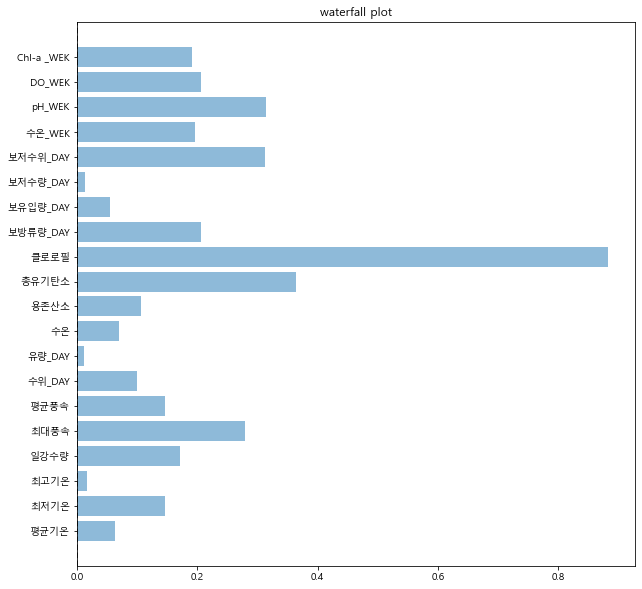

In [36]:
result = np.array(vars_shap_list).reshape(x_features, 10)

# normalize result
result = result / result.max()

shap_df = pd.DataFrame(result, columns=delta_x, index=input_cols)
# calculate one sensitivity value by shap_df
shap_df['one_sensi'] = shap_df.apply(lambda x: x.max() - x.min(), axis=1)
# shap_df['one_sensi'] = shap_df['one_sensi'] - shap_df['one_sensi'].mean()
# shap_df = shap_df.iloc[:-1]

# plot waterfall plot by shap_df['one_sensi']
# 1. y axis : input_cols
# 2. x axis : one_sensi value and middle line (0)
# 3. size : one_sensi value


fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')
plt.barh(shap_df.index, shap_df['one_sensi'], alpha=0.5)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('waterfall plot')
plt.savefig('./model_attn/result/waterfall_plot.png', facecolor='white', dpi=300)
plt.show()


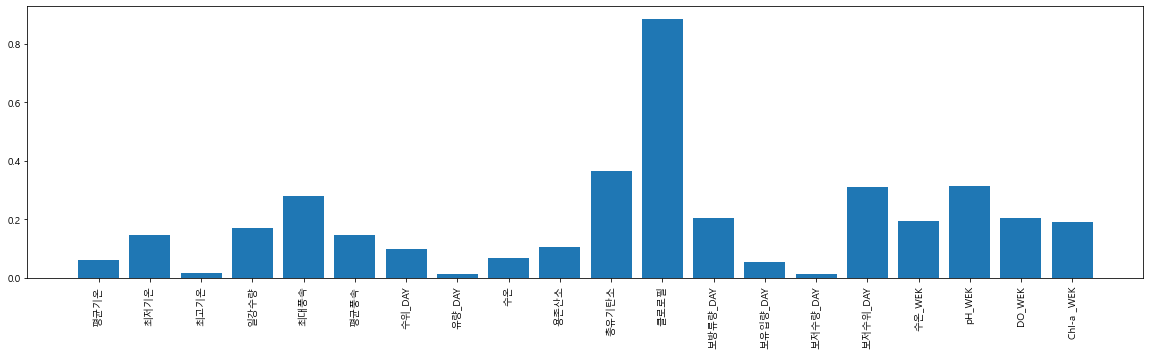

In [37]:
# plot one_sensi
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_facecolor('white')
plt.bar(shap_df.index, shap_df['one_sensi'])
plt.xticks(rotation=90)
plt.savefig('./model_attn/result/case07/one_sensi.png', facecolor='white', dpi=300)
plt.show()
plt.close()

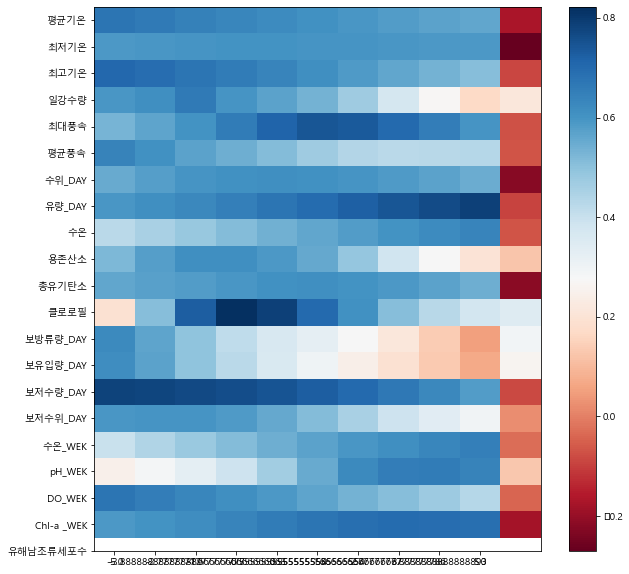

In [ ]:
# #plot waterfall plots of shap df
# # 1. y axis : input variable
# # 2. x axis : delta_y
# # 3. color : delta_x
# # 4. wideley used colormap : RdBu
# # tick plot
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_facecolor('white')
# plt.imshow(shap_df, cmap='RdBu', aspect='auto')
# plt.yticks(np.arange(len(input_cols)), input_cols)
# plt.xticks(np.arange(len(delta_x)), delta_x)
# plt.colorbar()
# plt.show()